## How do Embeddings Change with Different Learning Rates?

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from openTSNE import TSNE

# for local imports  
from pathlib import Path
import sys

script_dir = Path.cwd().parent / "scripts"
sys.path.append(str(script_dir))

import datasets
import quality_measures

2025-03-02 21:40:15.930410: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
X, y = datasets.load_mnist()

# this line is just for quick testing and should be commented out for the final experiments 
X, y = datasets.load_n_samples(500, X, y)

In [24]:
learning_rates = [1, 50, 200, 800, "auto"]
seeds = [1, 12, 42]

### functions for running t-sne and plotting results and embedding quality 

In [25]:
def run_tsne(data, labels, learning_rates, seeds, verbose=False): 
    """Returns embedding dictionary with keys given by learning rate and seed used to generate the embedding."""
    embedding_dict = {}
    for eta in tqdm(learning_rates): 
        for seed in tqdm(seeds): 
            tsne = TSNE(learning_rate=eta, n_jobs=-1, random_state=seed, verbose=verbose)
            embedding = tsne.fit(data)
            embedding_dict[(seed, eta)] = (embedding, labels)
    
    return embedding_dict 

In [7]:
def plot_embedding_grid(row_parameter, column_parameter, row_string, column_string, embeddings):
    """
    Plots a grid of t-SNE embeddings.

    Parameters:
    - row_parameter (list): Values to be assigned to rows (e.g., exaggeration values).
    - column_parameter (list): Values to be assigned to columns (e.g., iterations).
    - row_string (str): Label for the row axis.
    - column_string (str): Label for the column axis.
    - embeddings (dict): A dictionary where keys are (row_value, col_value) tuples,
                         and values are (embedding_array, labels).
    """

    num_rows = len(row_parameter)
    num_cols = len(column_parameter)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows), squeeze=False)

    # Plot embeddings
    for row_idx, row_value in enumerate(row_parameter):
        for col_idx, col_value in enumerate(column_parameter):
            ax = axes[row_idx, col_idx]

            embedding, labels = embeddings[(row_value, col_value)]
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap="Set1", s=5)
            ax.set_xticks([])
            ax.set_yticks([])

            # Remove plot outlines 
            for spine in ax.spines.values():
                spine.set_visible(False)

            # Add column headers (column values)
            if row_idx == 0:
                ax.set_title(f"{column_string}: {col_value}", fontsize=12, pad=10)

            # Add row labels (row values)
            if col_idx == 0:
                ax.set_ylabel(f"{row_string}: {row_value}", fontsize=12, labelpad=10)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()


### Running the embedding

In [26]:
embedding_dict = run_tsne(X, y, learning_rates, seeds, verbose=False)

100%|██████████| 5/5 [02:45<00:00, 33.01s/it]


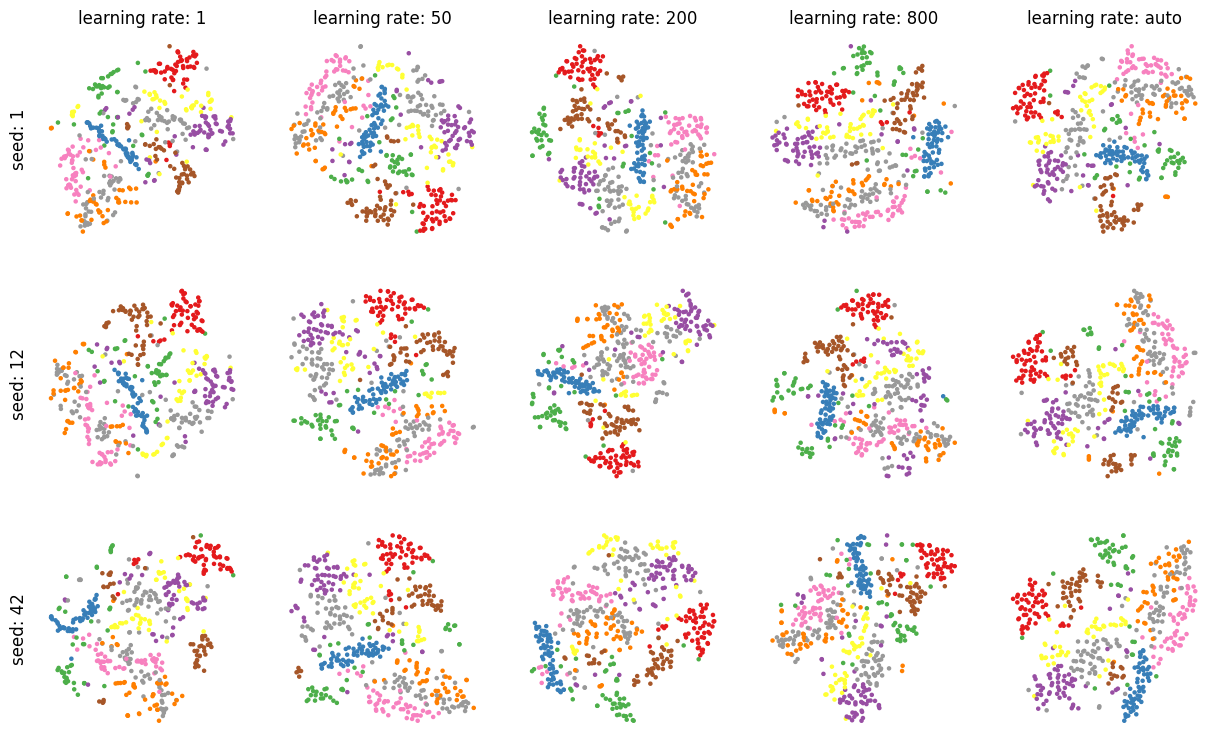

In [27]:
plot_embedding_grid(seeds, learning_rates, "seed", "learning rate", embedding_dict)

In [28]:
# this is the code from Kobak et al
from quality_measures import embedding_quality

In [29]:
import numpy as np 
def average_quality_measures(embedding_dict, X):
    """
    Computes the average quality measures across different seeds for each learning rate.

    Parameters:
        embedding_dict (dict): Dictionary with (seed, learning_rate) as keys and (embedding, labels) as values.
        X (numpy.ndarray): Original high-dimensional data.
        y (numpy.ndarray): Class labels.

    Returns:
        dict: Dictionary with learning_rate as keys and averaged (mnn, mnn_global, rho) as values.
    """
    quality_results = {}

    # Extract all unique learning rates
    learning_rates = set(eta for _, eta in embedding_dict.keys())

    for eta in learning_rates:
        mnn_list, mnn_global_list, rho_list = [], [], []

        for seed in [key[0] for key in embedding_dict.keys() if key[1] == eta]:
            embedding, labels = embedding_dict[(seed, eta)]
            mnn, mnn_global, rho = embedding_quality(X, embedding, labels)

            mnn_list.append(mnn)
            mnn_global_list.append(mnn_global)
            rho_list.append(rho)

        # Compute averages
        quality_results[eta] = (
            np.mean(mnn_list), 
            np.mean(mnn_global_list), 
            np.mean(rho_list)
        )

    return quality_results


In [31]:
import scipy
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
def embedding_quality(X, Z, classes, knn=10, knn_classes=10, subsetsize=1000):
    # ensure data is in the form of a numpy array for this function 
    X = np.array(X) if not isinstance(X, np.ndarray) else X
    Z = np.array(Z) if not isinstance(Z, np.ndarray) else Z

    # measuring local embedding quality 
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    # measuring class preservation 
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    # to make sure we can handle less than 10 classes as well 
    effective_knn_classes = min(knn_classes, C - 1) 
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=effective_knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=effective_knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    # measuring global embedding quality 
    size_of_subset = min(X.shape[0], subsetsize)
    subset = np.random.choice(X.shape[0], size=size_of_subset, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

In [21]:
def plot_quality_measures(quality_results):
    """
    Plots three side-by-side plots for the three embedding quality measures.

    Parameters:
        quality_results (dict): Dictionary with learning_rate as keys and averaged (mnn, mnn_global, rho) as values.
    """
    # Separate numeric and "auto" learning rates
    numeric_lrs = sorted([eta for eta in quality_results.keys() if isinstance(eta, (int, float))])
    auto_lr = ["auto"] if "auto" in quality_results else []

    # Final ordered learning rates
    learning_rates = numeric_lrs + auto_lr

    # Extract values in the new order
    mnn_values = [quality_results[eta][0] for eta in learning_rates]
    mnn_global_values = [quality_results[eta][1] for eta in learning_rates]
    rho_values = [quality_results[eta][2] for eta in learning_rates]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Convert learning rates to strings for better readability on x-axis
    learning_rate_labels = [str(eta) for eta in learning_rates]

    axes[0].plot(learning_rate_labels, mnn_values, marker='o', linestyle='-')
    axes[0].set_title("Mean Nearest Neighbor Retention (MNN)")
    axes[0].set_xlabel("Learning Rate")
    axes[0].set_ylabel("MNN")

    axes[1].plot(learning_rate_labels, mnn_global_values, marker='s', linestyle='-')
    axes[1].set_title("Global Mean Nearest Neighbor Retention (MNN Global)")
    axes[1].set_xlabel("Learning Rate")
    axes[1].set_ylabel("MNN Global")

    axes[2].plot(learning_rate_labels, rho_values, marker='^', linestyle='-')
    axes[2].set_title("Spearman Correlation (ρ)")
    axes[2].set_xlabel("Learning Rate")
    axes[2].set_ylabel("ρ")

    plt.tight_layout()
    plt.show()


In [32]:
quality_results = average_quality_measures(embedding_dict, X)

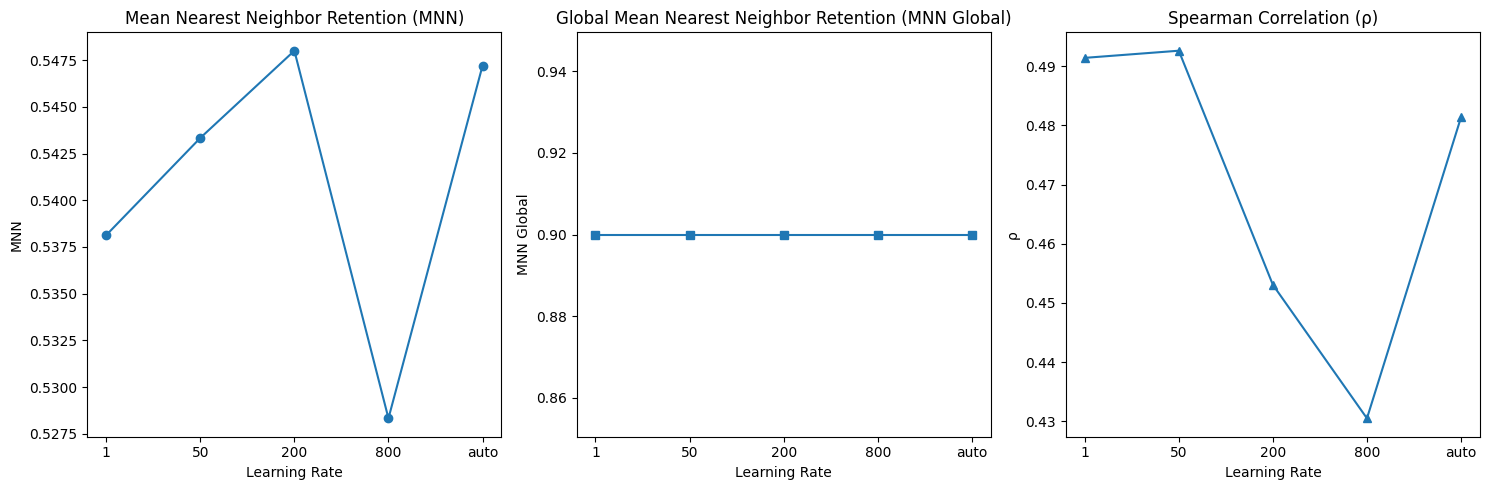

In [33]:
plot_quality_measures(quality_results)